In [1]:
# this notbook is to dev adversarial attacks vs a network

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

from advertorch import attacks
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 7000

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

In [8]:
# load classic model
classic_model_name = "sample_classic_model"
save_path = "../Experiments/sample_models/"
classic_model = torch.load(save_path+classic_model_name+"_full.pth")
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
# test the model
# loss functions for the classic net      
classical_cross_ent_loss = (lambda model,output,target:  F.cross_entropy(output,target.long()))

classic_test_res = fgnh.test(classic_model, mnist_train_loader, classical_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2450, Accuracy: 55717/60000 (93%)


In [10]:
# load fgn model
fgn_model_name = "sample_fgn_model"
save_path = "../Experiments/sample_models/"
fgn_model = torch.load(save_path+fgn_model_name+"_full.pth")
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [11]:
# test the model
### Loss Functions for the FGN
fgn_cross_ent_loss = (lambda model,output,target:  F.cross_entropy(output,target.long()))

fgn_test_res = fgnh.test(fgn_model, mnist_train_loader, fgn_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2956, Accuracy: 54639/60000 (91%)


In [12]:
# load data
for cln_data, true_label in mnist_train_loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [13]:
# minimum/maximum pixel value post normalization
min_pix = np.min(cln_data.cpu().numpy())
max_pix = np.max(cln_data.cpu().numpy())
print(min_pix, max_pix)
# theoritical minimum
print( (0.0/255-0.1307)/0.3081 )
# theoritical maximum
print( (255.0/255-0.1307)/0.3081 )


-0.42421296 2.8214867
-0.424212917884
2.82148653035


In [14]:
# Construct an adversary instance

#maximum distortion allowed
max_dists = float(max_pix-min_pix)/5.0

classic_adversary = attacks.PGDAttack(
    classic_model, loss_fn=F.cross_entropy, eps=max_dists, ord=np.inf,
    nb_iter=1000, eps_iter=0.01, rand_init=True, clip_min=min_pix, clip_max=max_pix,
    targeted=False)

In [15]:
# Perform untargeted attack
classic_adv_untargeted = classic_adversary.perturb(cln_data, true_label)

In [16]:
# Perform targeted attack
target_class = 0
target = torch.ones_like(true_label) * target_class
classic_adversary.targeted = True
classic_adv_targeted = classic_adversary.perturb(cln_data, target)

<IPython.core.display.Javascript object>


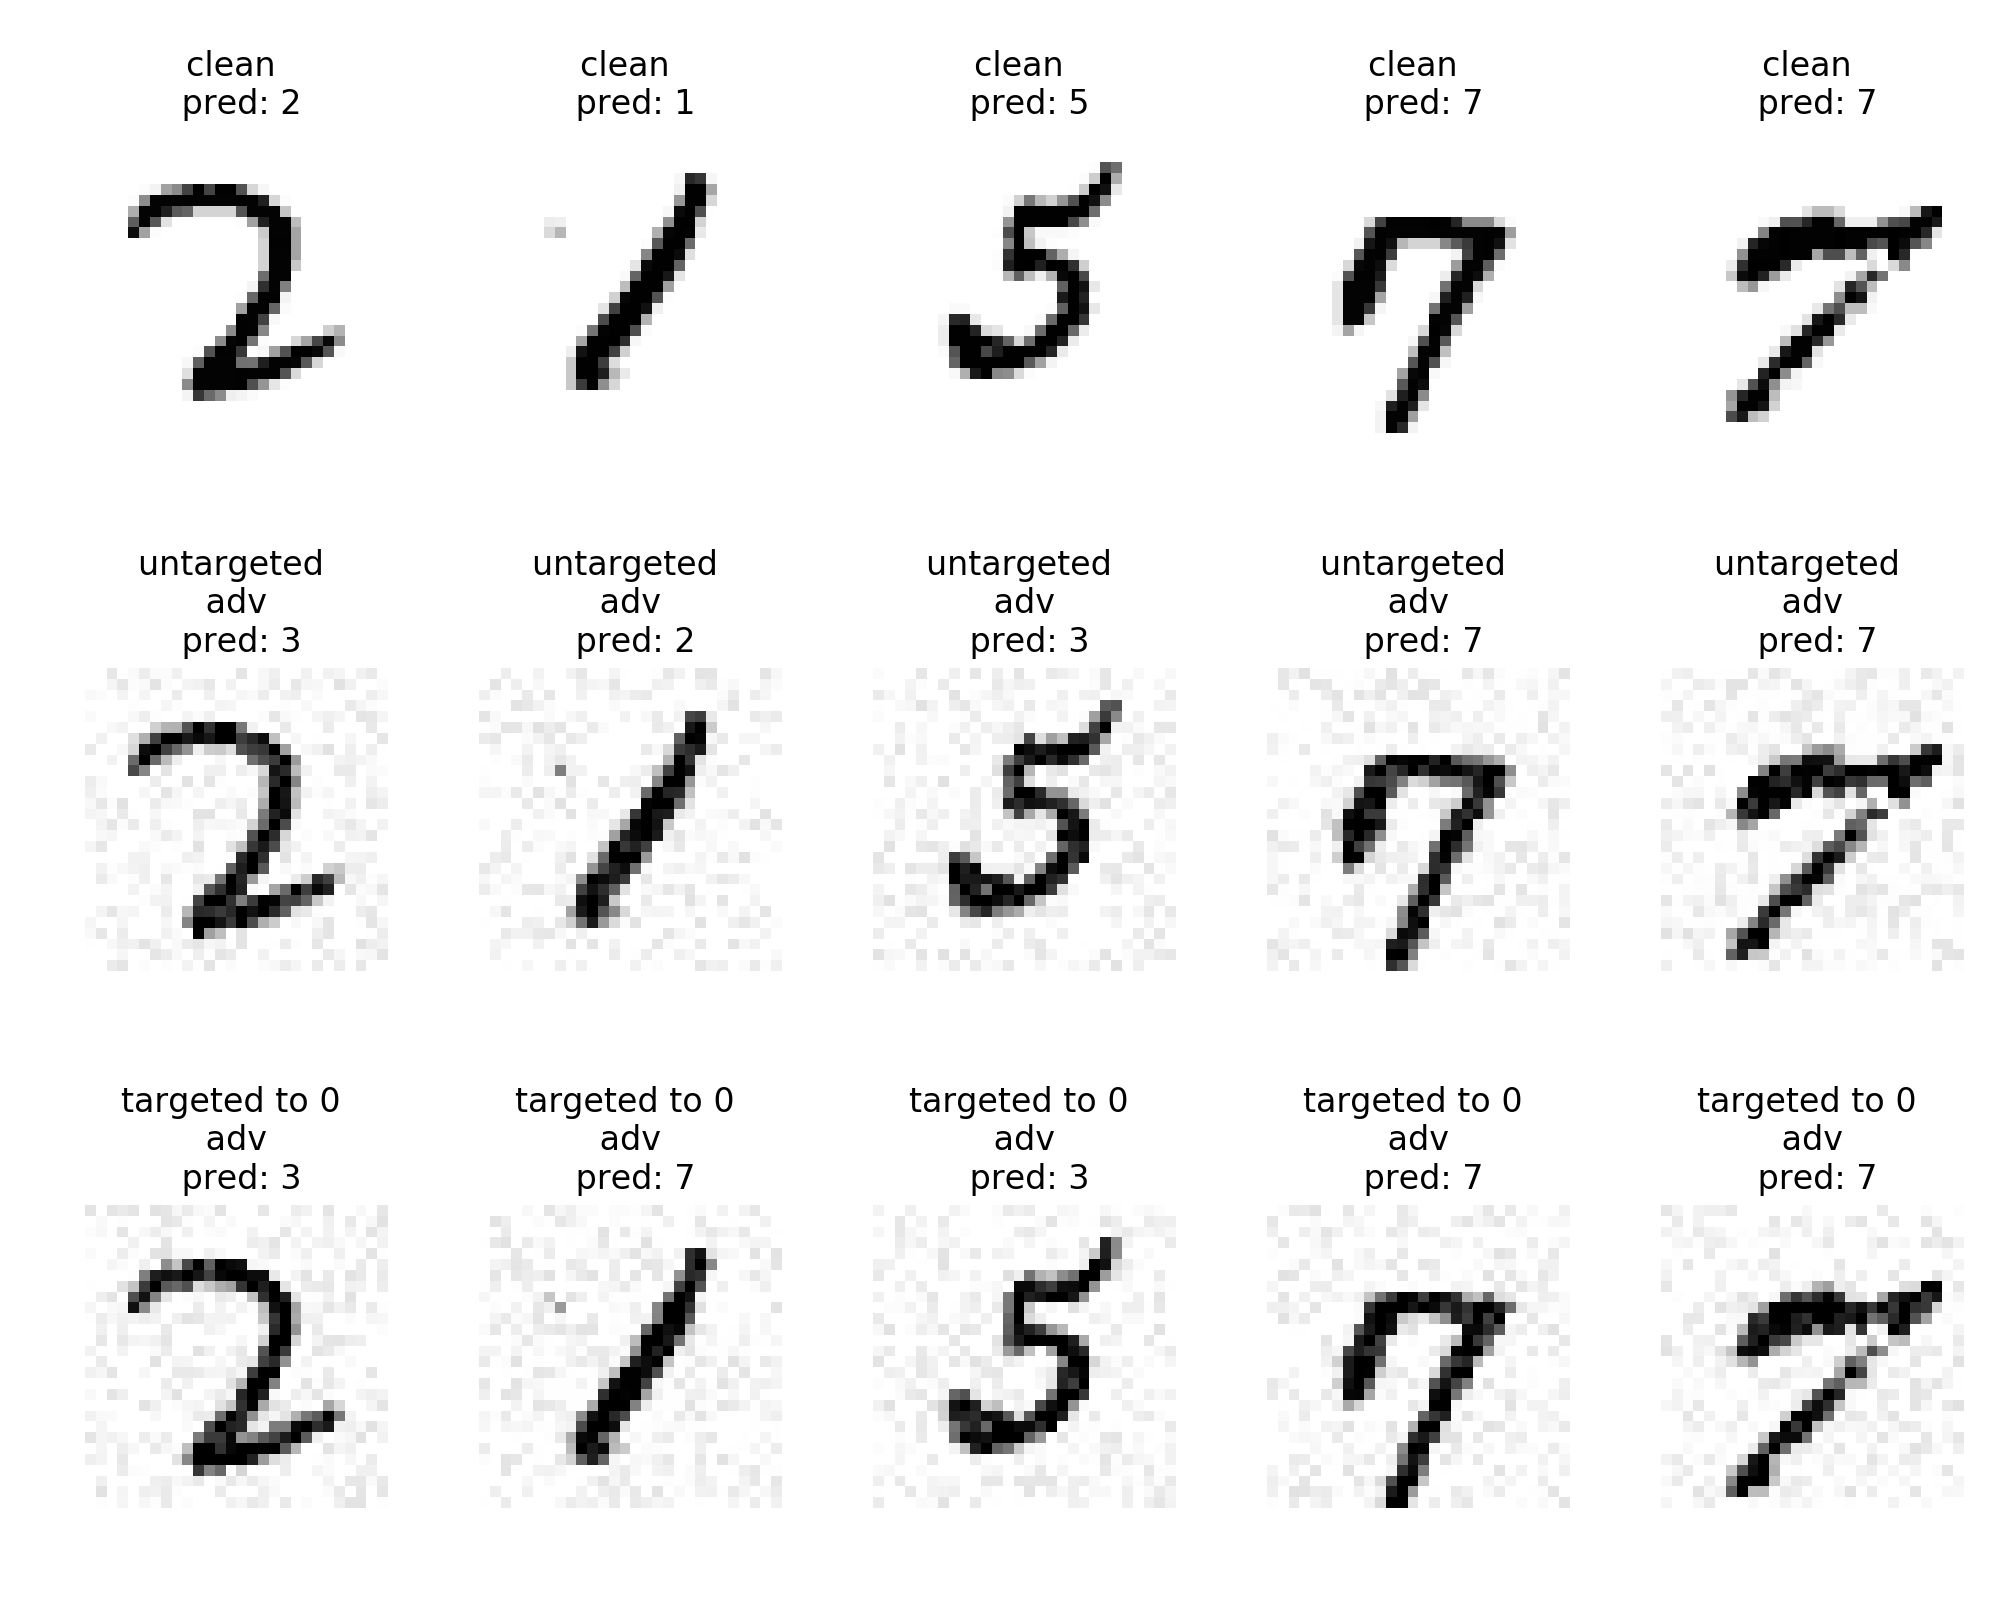

In [17]:
# Visualization of attacks
pred_cln = predict_from_logits(classic_model(cln_data))
pred_untargeted_adv = predict_from_logits(classic_model(classic_adv_untargeted))
pred_targeted_adv = predict_from_logits(classic_model(classic_adv_targeted))

num_to_plot = 5
plt.figure(figsize=(10, 8))
for ii in range(num_to_plot):
    plt.subplot(3, num_to_plot, ii + 1)
#     _imshow(cln_data[ii])
    x_to_plot = cln_data[ii].cpu().numpy().reshape((28,28))
    plt.imshow(x_to_plot, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    plt.axis("off")
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    
    plt.subplot(3, num_to_plot, ii + 1 + num_to_plot)
#     _imshow(classic_adv_untargeted[ii])
    x_to_plot = classic_adv_untargeted[ii].cpu().numpy().reshape((28,28))
    plt.imshow(x_to_plot, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    plt.axis("off")
    plt.title("untargeted \n adv \n pred: {}".format(pred_untargeted_adv[ii]))
    
    plt.subplot(3, num_to_plot, ii + 1 + num_to_plot * 2)
    #     _imshow(classic_adv_targeted[ii])
    x_to_plot = classic_adv_targeted[ii].cpu().numpy().reshape((28,28))
    plt.imshow(x_to_plot, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    plt.axis("off")
    plt.title("targeted to {} \n adv \n pred: {}".format(target_class,pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


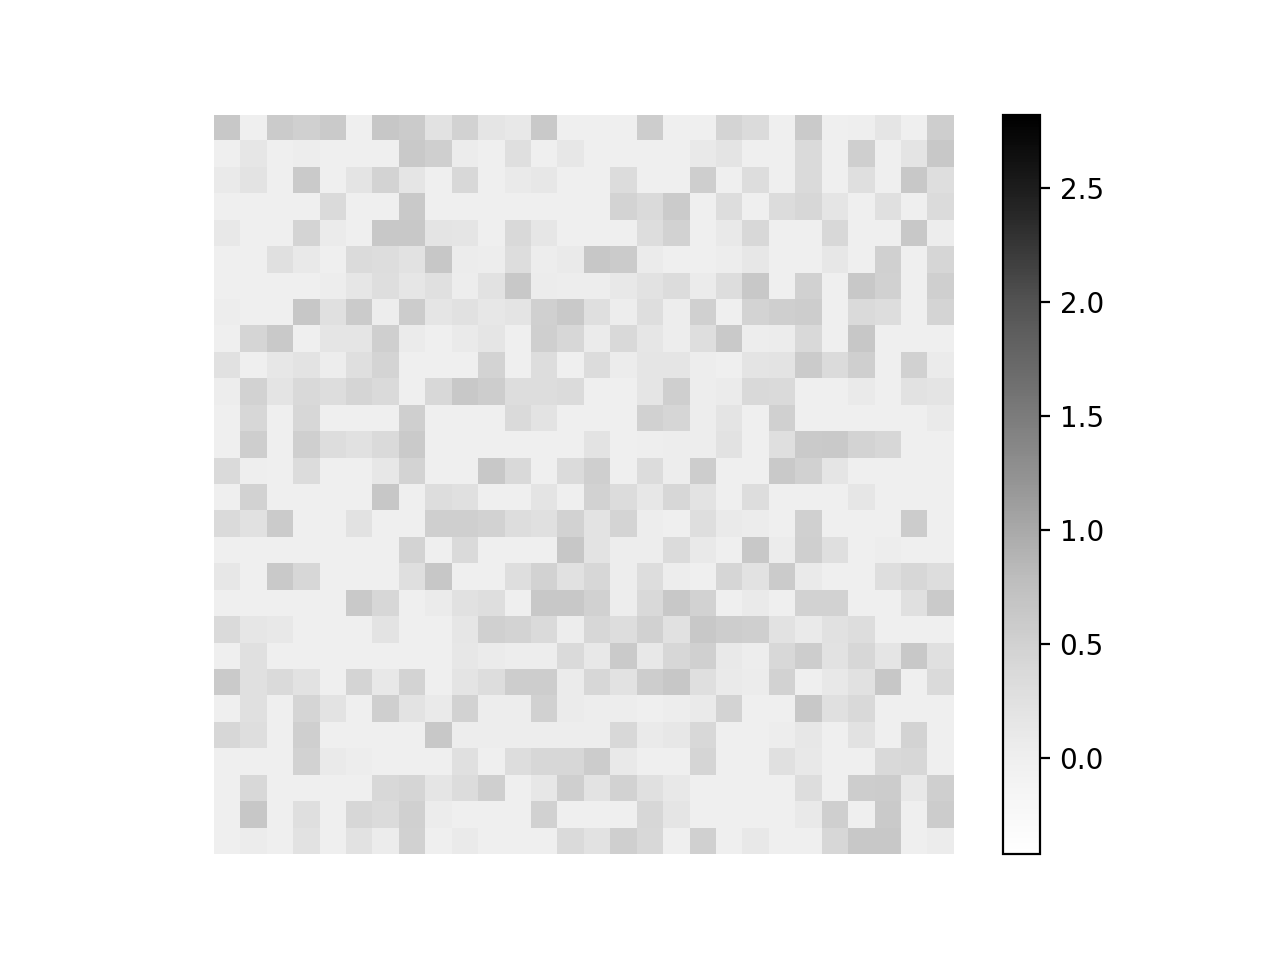

In [18]:
# visualize some noise
noise = np.abs(cln_data[0].cpu().numpy().reshape((28,28))-classic_adv_targeted[0].cpu().numpy().reshape((28,28)))
# x = cln_data[0].cpu().numpy().reshape((28,28))
# print(np.max(x))
plt.imshow(noise, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
plt.axis("off")
plt.colorbar()
plt.show()
# cln_data[ii].cpu().numpy().reshape((28,28))

In [19]:
# some stats:
# % of succesful untargeted attacks
classic_prc_succ_untargeted = np.sum((pred_untargeted_adv != true_label).cpu().numpy())/len(pred_untargeted_adv)
print("untargeted:", classic_prc_succ_untargeted)

# % of succesful targeted attacks
classic_prc_succ_targeted = np.sum((pred_targeted_adv == target).cpu().numpy())/len(pred_targeted_adv)
print("targeted:", classic_prc_succ_targeted)

# average distortion?

untargeted: 0.8367142857142857
targeted: 0.008


In [20]:
# Construct an adversary instance

#maximum distortion allowed
max_dists = float(max_pix-min_pix)/5.0

fgn_adversary = attacks.PGDAttack(
    fgn_model, loss_fn=F.cross_entropy, eps=max_dists, ord=np.inf,
    nb_iter=1000, eps_iter=0.01, rand_init=True, clip_min=min_pix, clip_max=max_pix,
    targeted=False)

In [21]:
# Perform untargeted attack
fgn_adv_untargeted = fgn_adversary.perturb(cln_data, true_label)

In [22]:
# Perform targeted attack
target_class = 0
target = torch.ones_like(true_label) * target_class
fgn_adversary.targeted = True
fgn_adv_targeted = fgn_adversary.perturb(cln_data, target)


<IPython.core.display.Javascript object>


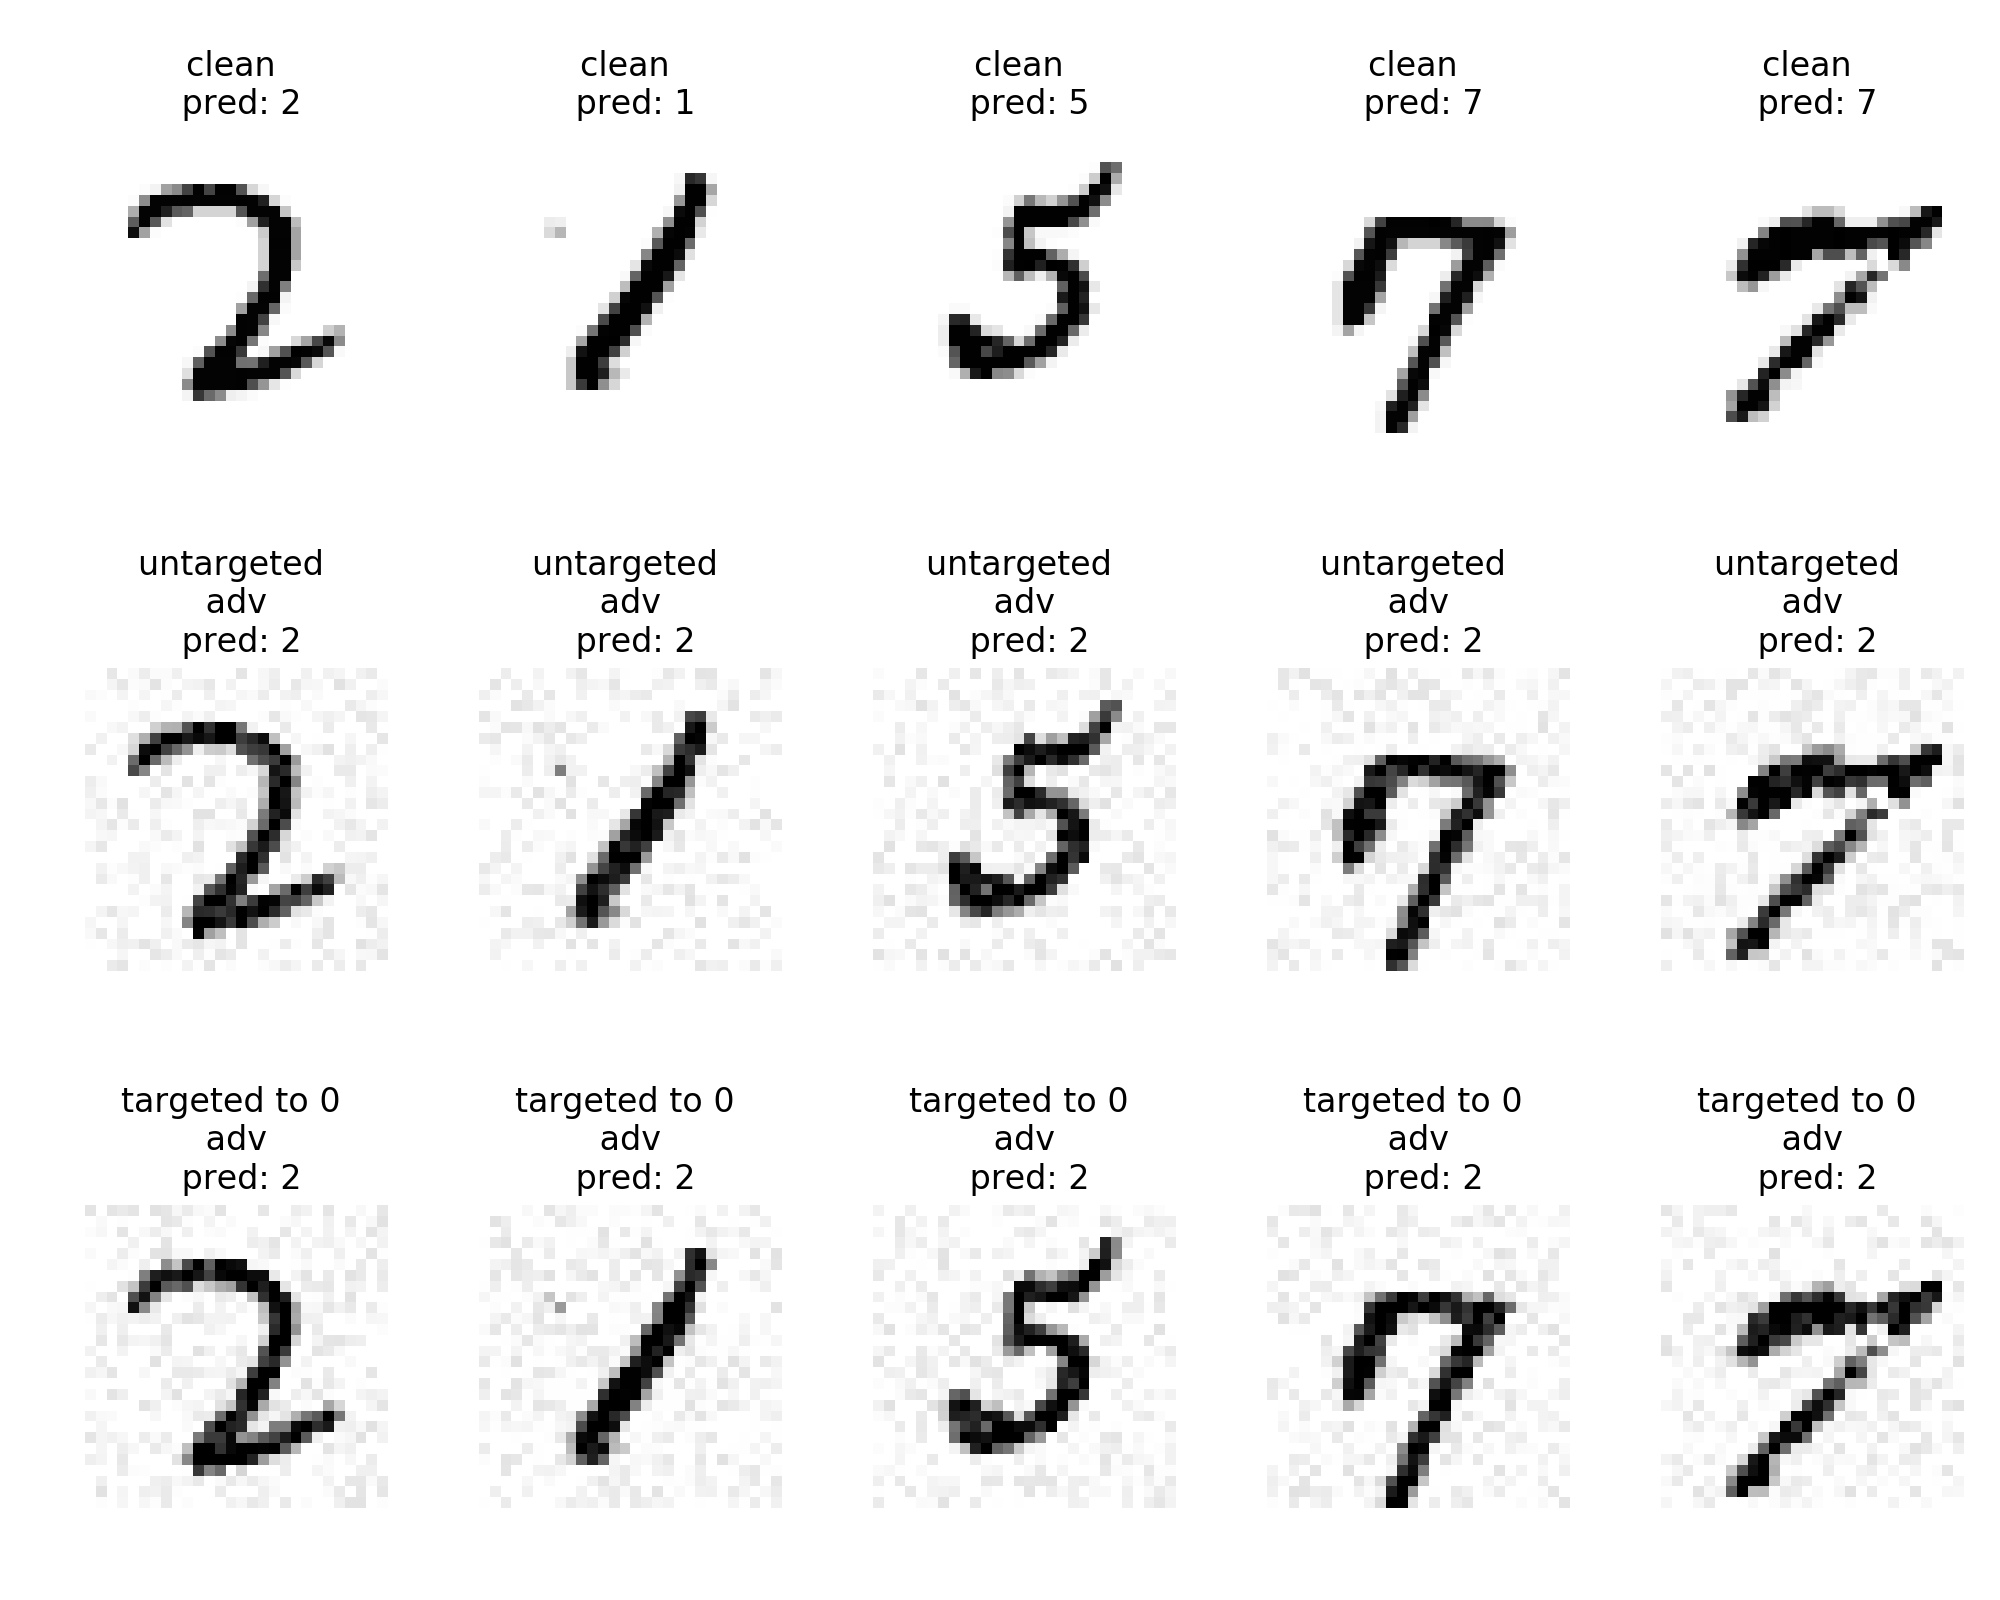

In [23]:
# Visualization of attacks

pred_cln = predict_from_logits(fgn_model(cln_data))
pred_untargeted_adv = predict_from_logits(fgn_model(fgn_adv_untargeted))
pred_targeted_adv = predict_from_logits(fgn_model(fgn_adv_targeted))

num_to_plot = 5
plt.figure(figsize=(10, 8))
for ii in range(num_to_plot):
    plt.subplot(3, num_to_plot, ii + 1)
#     _imshow(cln_data[ii])
    x_to_plot = cln_data[ii].cpu().numpy().reshape((28,28))
    plt.imshow(x_to_plot, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    plt.axis("off")
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    
    plt.subplot(3, num_to_plot, ii + 1 + num_to_plot)
#     _imshow(classic_adv_untargeted[ii])
    x_to_plot = classic_adv_untargeted[ii].cpu().numpy().reshape((28,28))
    plt.imshow(x_to_plot, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    plt.axis("off")
    plt.title("untargeted \n adv \n pred: {}".format(pred_untargeted_adv[ii]))
    
    plt.subplot(3, num_to_plot, ii + 1 + num_to_plot * 2)
    #     _imshow(classic_adv_targeted[ii])
    x_to_plot = classic_adv_targeted[ii].cpu().numpy().reshape((28,28))
    plt.imshow(x_to_plot, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    plt.axis("off")
    plt.title("targeted to {} \n adv \n pred: {}".format(target_class,pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


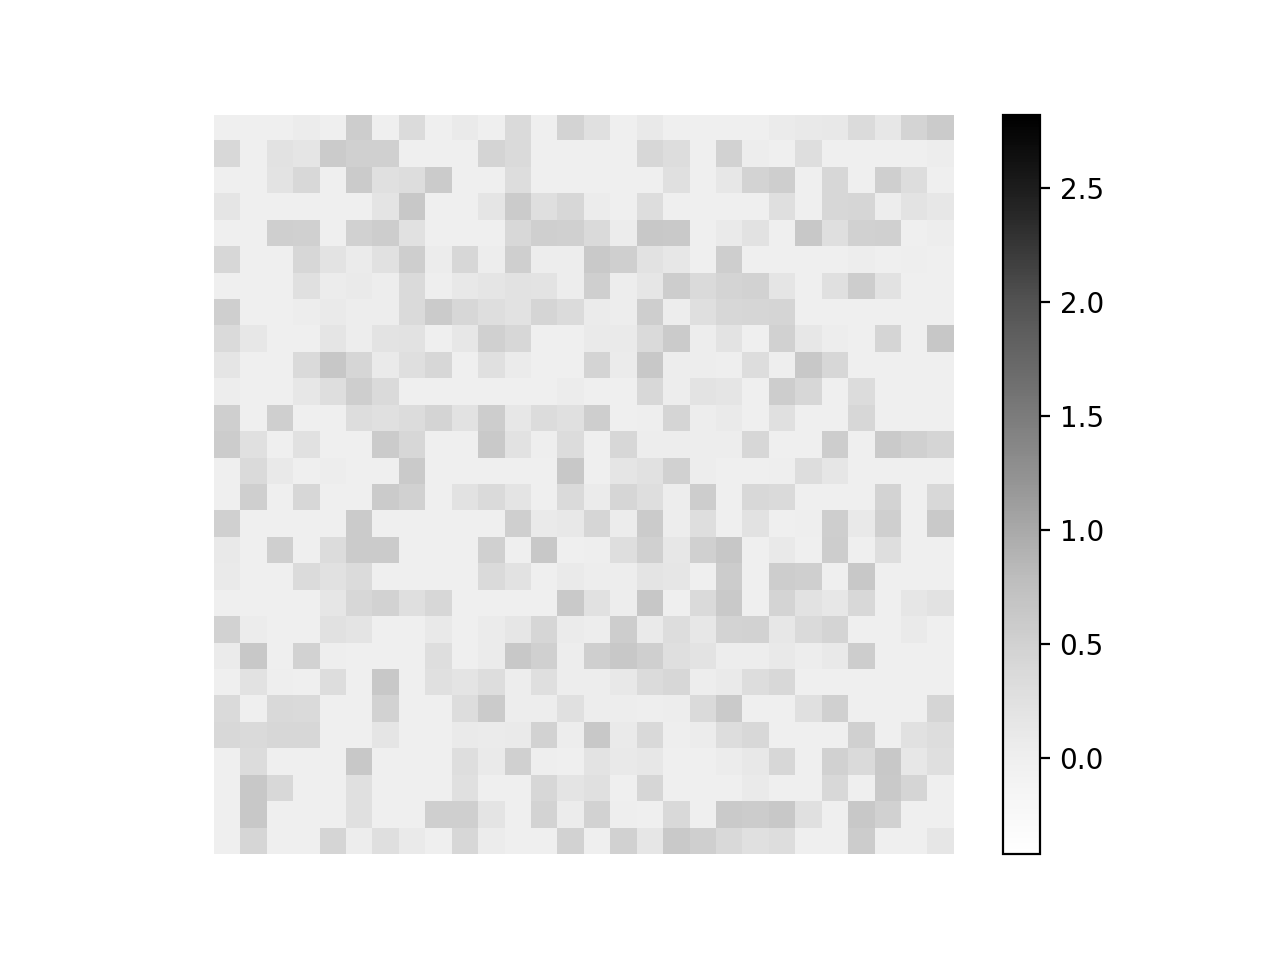

In [24]:
# visualize some noise
noise = np.abs(cln_data[0].cpu().numpy().reshape((28,28))-fgn_adv_targeted[0].cpu().numpy().reshape((28,28)))
# x = cln_data[0].cpu().numpy().reshape((28,28))
# print(np.max(x))
plt.imshow(noise, cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
plt.axis("off")
plt.colorbar()
plt.show()
# cln_data[ii].cpu().numpy().reshape((28,28))

In [25]:
# some stats:
# % of succesful untargeted attacks
fgn_prc_succ_untargeted = np.sum((pred_untargeted_adv != true_label).cpu().numpy())/len(pred_untargeted_adv)
print("untargeted:", fgn_prc_succ_untargeted)

# % of succesful targeted attacks
fgn_prc_succ_targeted = np.sum((pred_targeted_adv == target).cpu().numpy())/len(pred_targeted_adv)
print("targeted:", fgn_prc_succ_targeted)

# average distortion?

untargeted: 0.9007142857142857
targeted: 0.0
